# Principal Component Analysis

This notebook demonstrates the mechanics of Principal Component Analysis (PCA). One common use of PCA is data dimension reduction. For example, if you have a set of data $X$, where $X$ is a matrix of $n$ rows and $m$ columns, you might want to transform that data into $E$, where $E$ is a matrix of $n$ rows and $k$ columns ($k << m$). Transforming $X$ to $E$ might prove useful for use with downstream machine learning activities such as clustering where distance metrics break down in high dimensional space. 

The PCA algorithm applied to a data matrix $X$ is as follows.

* $Z = T_Z(X)$, where $T_Z$ converts the data in $X$ into [z-scores](https://en.wikipedia.org/wiki/Standard_score)
* $C = T_C(Z)$, where $T_C$ computes the covariance matrix of $Z$
* $USU' = T_S(C)$, where $T_S$ performs singular value decomposition (SVD) on $C$

## Manual PCA computation

### Sampling

Below, we sample data from two multivariate normal distributions to create $X$.

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
from numpy.random import normal
from numpy.linalg import inv, svd
import pandas as pd
from collections import namedtuple
import seaborn as sns

DATA = namedtuple('DATA', 'X y df')
_seed = 37
np.random.seed(_seed)
np.set_printoptions(precision=3, suppress=True)

def get_data(N=1000):
    x0 = normal(1, 1, N)
    x1 = normal(3 + 2 * x0, 1, N)
    x2 = normal(2.5 + 0.8 * x1, N)
    x3 = normal(5, 2, N)
    x4 = normal(0.8 + 0.8 * x3, N)
    x5 = normal(10, 5, N)

    X0 = [x0, x1, x2, x3, x4, x5]
    X0 = np.hstack([x.reshape(-1, 1) for x in X0])

    x0 = normal(1.5, 1, N)
    x1 = normal(7.3 + 2 * x0, 1, N)
    x2 = normal(3.6 + 0.9 * x1, N)
    x3 = normal(3.3, 2.5, N)
    x4 = normal(0.9 - 0.4 * x3, N)
    x5 = normal(10, 5, N)

    X1 = [x0, x1, x2, x3, x4, x5]
    X1 = np.hstack([x.reshape(-1, 1) for x in X1])

    X = np.vstack([X0, X1])
    y = np.hstack([np.full((1, X0.shape[0]), 0), np.full((1, X1.shape[0]), 1)])[0]
    c = ['zero' if val == 0.0 else 'one' for val in y]

    columns = ['X{}'.format(i) for i in range(X.shape[1])]
    X_df = pd.DataFrame(X, columns=columns)
    X_df['y'] = c
    
    return DATA(X, y, X_df)

def z_scale(D):
    m = D.X.mean(axis=0)
    s = D.X.std(axis=0)
    Z = ((D.X - m) / s)
    return Z
    
def get_cov(X):
    m = X.mean(axis=0)
    C = ((X - m).T.dot(X - m)) / X.shape[0]
    return C

Note

* `D` is the data
* `Z` is the scaled data
* `C` is the covariance matrix

In [2]:
D = get_data()

In [3]:
Z = z_scale(D)
print(Z.shape)

(2000, 6)


In [4]:
C = get_cov(Z)
print(C.shape)

(6, 6)


### Covariance

The covariance matrix is plotted below.

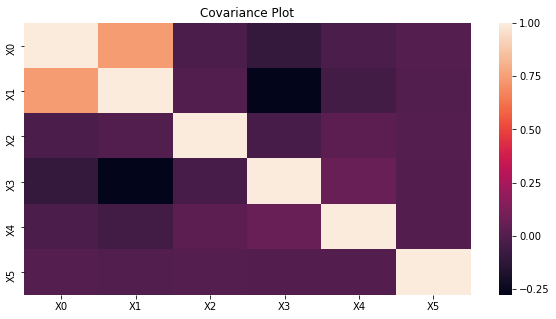

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
x_labels = ['X{}'.format(i) for i in range(C.shape[0])]
sns.heatmap(C, xticklabels=x_labels, yticklabels=x_labels, ax=ax)
ax.set_title('Covariance Plot')
plt.show()

### Singular value decomposition

Now we are ready to apply singular value decomposition (SVD) to `C`. SVD produces three matrices.

* `U` left-hand eigenvectors
* `S` eigenvalues (not a matrix unless you diagonalize)
* `VT` right-hand eigenvectors

$USV' = C$

We will see later that in the Scikit-Learn, the PCA class has

* `S` as the `explained_variance_`
* `VT` as the `components_`

In [6]:
U, S, VT = svd(C, full_matrices=False)

In [7]:
print('U')
print(U)
print(U.shape)

print()
print('S')
print(S)
print(S.shape)

print()
print('VT')
print(VT)
print(VT.shape)

U
[[-0.651  0.054  0.239 -0.043  0.243 -0.675]
 [-0.687  0.047  0.083 -0.004  0.058  0.718]
 [ 0.012  0.728 -0.53   0.164  0.404 -0.007]
 [ 0.309  0.001  0.546 -0.11   0.752  0.172]
 [ 0.086  0.672  0.577  0.003 -0.457  0.009]
 [-0.001  0.121 -0.159 -0.979 -0.03   0.006]]
(6, 6)

S
[1.835 1.025 1.017 0.999 0.89  0.234]
(6,)

VT
[[-0.651 -0.687  0.012  0.309  0.086 -0.001]
 [ 0.054  0.047  0.728  0.001  0.672  0.121]
 [ 0.239  0.083 -0.53   0.546  0.577 -0.159]
 [-0.043 -0.004  0.164 -0.11   0.003 -0.979]
 [ 0.243  0.058  0.404  0.752 -0.457 -0.03 ]
 [-0.675  0.718 -0.007  0.172  0.009  0.006]]
(6, 6)


The variances are as follows:

* `v_ratios` is the proportion of variance explained, and
* `c_var` is the cummulative variance going from the largest to smallest.

The eigenvectors in `S` represents the magntiude of the variance and its associated eigenvector.

In [8]:
v_ratios = S / S.sum()
c_var = np.array([v_ratios[0:v+1].sum() for v in range(len(v_ratios))])
print(v_ratios)
print(c_var)

[0.306 0.171 0.17  0.167 0.148 0.039]
[0.306 0.477 0.646 0.813 0.961 1.   ]


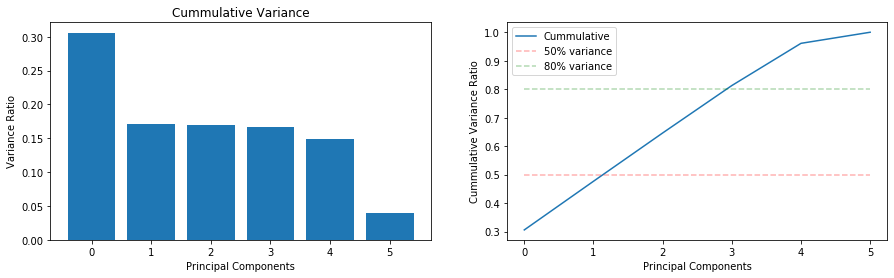

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

n_components = len(v_ratios)

ax[0].bar(range(n_components), v_ratios)
ax[1].plot(c_var, label='Cummulative')

ax[0].set_title('Variance Ratios')
ax[0].set_title('Cummulative Variance')

ax[0].set_xlabel('Principal Components')
ax[0].set_ylabel('Variance Ratio')

ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Cummulative Variance Ratio')

for v, c in zip([0.5, 0.8], ['r--', 'g--']):
    label = '{:.0f}% variance'.format(v * 100.0)
    ax[1].plot(
        (0, n_components - 1), 
        (v, v), c, alpha=0.3, 
        label=label)

ax[1].legend()

### Reconstructing the covariance matrix

You may reconstruct `C` from `U`, `S` and `VT` as follows. We use the `np.allclose` to detect for matches.

$C = USV'$

In [10]:
print(np.allclose(C, U.dot(np.diag(S)).dot(VT)))
print(np.allclose(C, np.dot(U * S, VT)))
print(np.allclose(C, np.dot(U, np.dot(np.diag(S), VT))))

True
True
True


### Principal components to variables

For PCA, `VT` or $V'$ is actually just $U'$. Below, we plot the influence of principal components to variables.

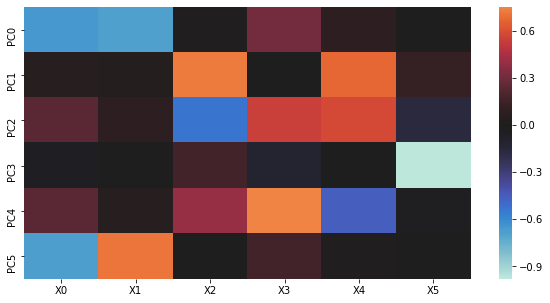

In [11]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5))
x_labels = ['X{}'.format(i) for i in range(VT.shape[1])]
y_labels = ['PC{}'.format(i) for i in range(VT.shape[0])]
sns.heatmap(VT, xticklabels=x_labels, yticklabels=y_labels, center=0.0, ax=ax)
plt.show()

### Variables to principal components

Here, we plot `U`. Notice how the graph is just the transpose of the one above? The way to intpret this plot is to go one PC at a time. When PC0 is high then $X0$ and $X1$ are lower; when PC1 is high, then $X2$ and $X4$ are high; and so on. 

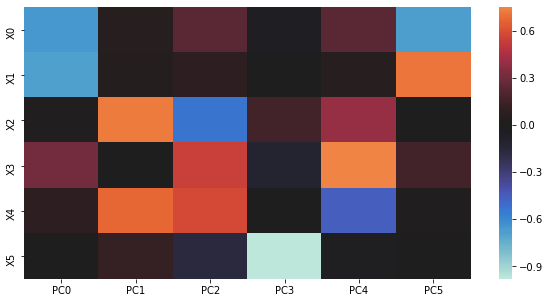

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
y_labels = ['X{}'.format(i) for i in range(U.shape[1])]
x_labels = ['PC{}'.format(i) for i in range(U.shape[0])]
sns.heatmap(U, xticklabels=x_labels, yticklabels=y_labels, center=0.0, ax=ax)
plt.show()

### Loadings squared

To understand how much each variable's variance contributes to each PC, we compute the loadings squared.

* `L` is the factor loading where columns correspond to PCs and rows correspond to variables; the i-th (row), j-th (column) element corresponds to the Pearson correlation coefficient between the i-th variable and j-th PC.
* `I` is the precentage of variance of a variable explained by the a PC; the i-th, j-th element corresponds to the percentage of variance of the i-th variable explained by the j-th PC.

[More information](ftp://statgen.ncsu.edu/pub/thorne/molevoclass/AtchleyOct19.pdf)

In [13]:
L = VT.T * np.sqrt(S)
print('loadings')
print(L)

I = np.power(L, 2)
print()
print('percentage of variance explained per variable per PC')
print(I)

# summing down the columns will give you the egienvalues
# equal to dividing eigenvalues by the number of variables
print()
print('percentage of variance explained over all variables per PC')
print(I.sum(axis=0) / I.shape[0])

print()
print('percentage of variance explained over all variables per PC*')
print(S / I.shape[0])

loadings
[[-0.882  0.054  0.241 -0.043  0.229 -0.326]
 [-0.931  0.047  0.083 -0.004  0.055  0.347]
 [ 0.017  0.736 -0.534  0.164  0.381 -0.003]
 [ 0.419  0.001  0.55  -0.11   0.709  0.083]
 [ 0.117  0.68   0.582  0.003 -0.431  0.005]
 [-0.002  0.123 -0.16  -0.979 -0.028  0.003]]

percentage of variance explained per variable per PC
[[0.779 0.003 0.058 0.002 0.052 0.106]
 [0.867 0.002 0.007 0.    0.003 0.12 ]
 [0.    0.542 0.285 0.027 0.145 0.   ]
 [0.176 0.    0.303 0.012 0.502 0.007]
 [0.014 0.462 0.338 0.    0.186 0.   ]
 [0.    0.015 0.026 0.958 0.001 0.   ]]

percentage of variance explained over all variables per PC
[0.306 0.171 0.17  0.167 0.148 0.039]

percentage of variance explained over all variables per PC*
[0.306 0.171 0.17  0.167 0.148 0.039]


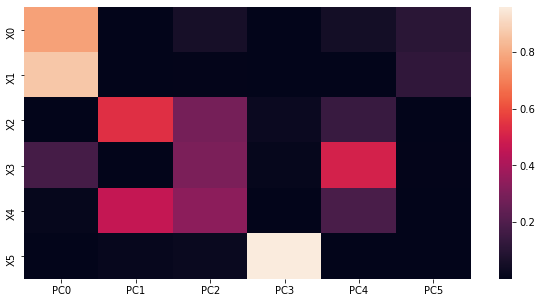

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
y_labels = ['X{}'.format(i) for i in range(I.shape[1])]
x_labels = ['PC{}'.format(i) for i in range(I.shape[0])]
sns.heatmap(I, xticklabels=x_labels, yticklabels=y_labels, ax=ax)
plt.show()

### Projecting data into PC space

If we had new data, we may project that data (after it has been scaled) into PC space. To project scaled values into PC space, $ZV$. The following are called the [raw component scores](https://stats.stackexchange.com/questions/102882/steps-done-in-factor-analysis-compared-to-steps-done-in-pca/102999#102999), and have variance equal to the eigenvalues.

In [15]:
print(np.dot(Z, VT.T))

[[ 0.785  0.533  0.36   1.555 -1.048 -0.61 ]
 [ 0.036 -1.228  0.604  0.229  0.063 -0.512]
 [ 0.385 -0.152 -0.344 -0.837 -0.442 -0.739]
 ...
 [-0.575  1.009 -1.673  0.675  0.014  0.213]
 [-1.966  0.449 -0.822 -0.61   1.139  0.674]
 [-0.893  0.409  0.265 -1.126  0.491  0.434]]


The standardize component scores are given by the following and have variance equal to 1.

$Z S^{-1} L$

In [16]:
B = inv(np.diag(S)).dot(L)
print(Z.dot(B))

[[ 0.943  0.042  1.261  6.329 -0.879 -0.345]
 [ 0.199 -1.473  0.768  1.763  0.096 -0.189]
 [ 0.531  0.19  -0.816 -3.609 -0.498 -0.329]
 ...
 [-0.829  0.865 -1.54   1.538  0.058  0.076]
 [-2.255  0.647 -1.387 -3.018  0.942  0.459]
 [-0.975  0.851 -0.361 -4.645  0.297  0.292]]


### Project data in PC space to scaled space

If we want to project from PC space back to the scaled space, then, $EV'^{-1}$. 

In [17]:
print('Z')
print(Z)

print('Z from PC space')
print(np.dot(np.dot(Z, VT.T), inv(VT.T)))

Z
[[-0.305 -0.99   0.042 -0.624  1.112 -1.489]
 [ 0.407 -0.397 -1.147  0.274 -0.506 -0.474]
 [ 0.086 -0.853 -0.235 -0.435 -0.075  0.864]
 ...
 [-0.14   0.455  1.728 -1.117 -0.339 -0.271]
 [ 0.955  1.857  1.094 -0.017 -0.859  0.755]
 [ 0.541  1.     0.157  0.437  0.126  1.099]]
Z from PC space
[[-0.305 -0.99   0.042 -0.624  1.112 -1.489]
 [ 0.407 -0.397 -1.147  0.274 -0.506 -0.474]
 [ 0.086 -0.853 -0.235 -0.435 -0.075  0.864]
 ...
 [-0.14   0.455  1.728 -1.117 -0.339 -0.271]
 [ 0.955  1.857  1.094 -0.017 -0.859  0.755]
 [ 0.541  1.     0.157  0.437  0.126  1.099]]


### Visualize data in PC space

Plot the data in PC space.

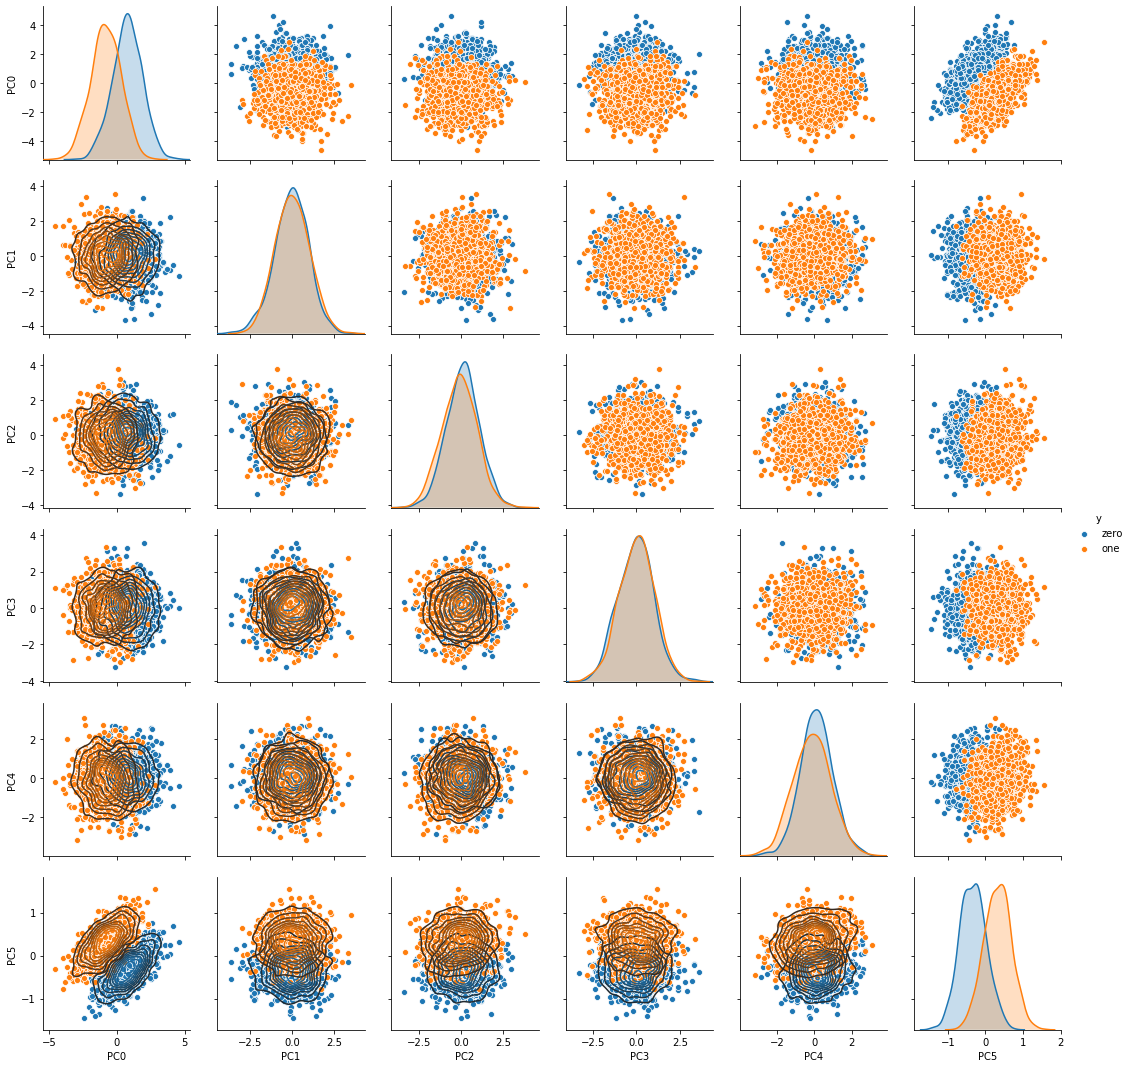

In [18]:
df = pd.DataFrame(np.dot(Z, VT.T), columns=['PC{}'.format(i) for i in range(VT.T.shape[1])])
df['y'] = D.df['y']

g = sns.pairplot(df, hue='y')
g.map_lower(sns.kdeplot, **{'shade': False, 'n_levels': 10})

## Verification with Scikit-Learn

Now we are going to do the same thing but using Scikit-Learn.

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=3, random_state=37)

pipeline = Pipeline([('scaler', scaler), ('pca', pca)])
pipeline.fit(D.X)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=3,
                     random_state=37, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)

### Right side eigenvectors

The components, right side eigenvectors, `VT` or $V'$.

In [20]:
print(pca.components_)

[[-0.651 -0.687  0.012  0.309  0.086 -0.001]
 [-0.054 -0.047 -0.728 -0.001 -0.672 -0.121]
 [ 0.239  0.083 -0.53   0.546  0.577 -0.159]]


### Eigenvalues

The eigenvalues or explained variance.

In [21]:
print(pca.explained_variance_)

[1.836 1.025 1.018]


### Loadings

The loadings.

In [22]:
print(pca.components_.T * np.sqrt(pca.explained_variance_))

[[-0.883 -0.054  0.241]
 [-0.932 -0.048  0.083]
 [ 0.017 -0.737 -0.534]
 [ 0.419 -0.001  0.551]
 [ 0.117 -0.68   0.582]
 [-0.002 -0.123 -0.16 ]]


### Explained variance

The contributions of each variable to a PC.

In [23]:
print(np.power(pca.components_.T * np.sqrt(pca.explained_variance_), 2))

[[0.779 0.003 0.058]
 [0.868 0.002 0.007]
 [0.    0.543 0.286]
 [0.176 0.    0.303]
 [0.014 0.462 0.339]
 [0.    0.015 0.026]]


### Projecting data into PC space

Transforming data into PC space.

In [24]:
print(pipeline.transform(D.X))

[[ 0.785 -0.533  0.36 ]
 [ 0.036  1.228  0.604]
 [ 0.385  0.152 -0.344]
 ...
 [-0.575 -1.009 -1.673]
 [-1.966 -0.449 -0.822]
 [-0.893 -0.409  0.265]]


### Visualize data in PC space

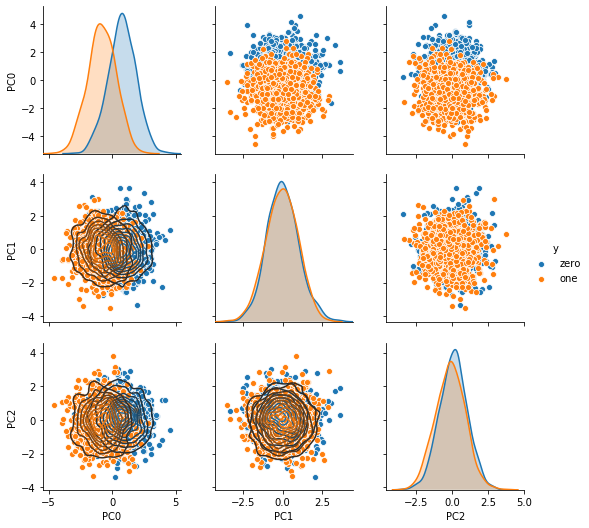

In [25]:
E = pipeline.transform(D.X)
df = pd.DataFrame(E, columns=['PC{}'.format(p) for p in range(E.shape[1])])
df['y'] = D.df['y']

g = sns.pairplot(df, hue='y')
g.map_lower(sns.kdeplot, **{'shade': False, 'n_levels': 10})